## Project to Weed Detection in Soybean Crops
#### The dataset was get in [Kaggle](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)

### Steps
#### Configuration
- Download dataset
- Configure os enviroments
- Imports dependencies
- Create global variables
- Get images from dataset
- Show image
- Split dataset to train and test

#### Start Learning with Keras
- Import keras
- Create callbacks (savePoint, reduce)
- Create a model for CNN
- Compile model
- Load model if exists
- Train model
- Evaluate model
- Fit model
- Show results

#### Reference :
[Kaggle notebook](https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97)

In [1]:
import os   
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Imports here
#https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/
##https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97
import cv2                 
import numpy as np   
import glob
import matplotlib.pyplot as plt 
from random import shuffle

In [3]:
data_dir = r'dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
width = 200
height = 200
channel = 3

num_file_per_directory = 1100 

all_files = [] 
for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file_per_directory]

print('Files size:', len(all_files))

data = []
labels = []
for idx, file in enumerate(all_files):
    img_array = cv2.resize(cv2.imread(file), (width, height))
    data.append(img_array)
    if 'broadleaf' in file :
        labels.append(0)
    elif 'grass' in file :
        labels.append(1)
    elif 'soil' in file :
        labels.append(2)
    else :
        labels.append(3)


Files size: 4400


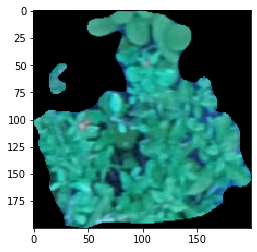

In [4]:
plt.imshow(data[0])
plt.show()

In [5]:
image_data = np.array(data)
labels = np.array(labels)
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(image_data, labels, test_size = 0.25, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)


### Start Learning with Keras

Documantation [keras](https://keras.io/)

In [6]:
from keras.utils import np_utils
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.models import Model
import os.path

y_train = np_utils.to_categorical(y_train, num_classes = 4)
y_test = np_utils.to_categorical(y_test, num_classes = 4)

Using TensorFlow backend.


In [7]:
filepath="keras_model_resnet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='auto')

In [8]:
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=3, min_lr=0.003)

In [9]:
#base_model = ResNet50(weights="imagenet",include_top=False)
import keras
base_model = MobileNet(weights="imagenet",include_top=False,  input_shape= (height, width,3))
avg = GlobalAveragePooling2D()(base_model.output)
#avg = MaxPooling2D(2,2)(base_model.output)
output = Dense(len(classes), activation="softmax")(avg)
model = Model(inputs=base_model.input, outputs=output)

D:\Programas\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 100, 32)      128 

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [12]:
def loadModel() :
    if os.path.isfile(filepath):
        model.load_weights(filepath)
loadModel()

In [13]:
x_train.shape

(2475, 200, 200, 3)

In [14]:
h = model.fit(x_train, y_train, epochs = 2, batch_size = 32, shuffle=True, callbacks=[lr_reduce, checkpoint])

Epoch 1/2
2475/2475 [==============================] - 513s 207ms/step - loss: 0.2724 - accuracy: 0.9273

Epoch 00001: accuracy improved from -inf to 0.92727, saving model to keras_model_resnet.h5
Epoch 2/2
2475/2475 [==============================] - 532s 215ms/step - loss: 0.0918 - accuracy: 0.9697

Epoch 00002: accuracy improved from 0.92727 to 0.96970, saving model to keras_model_resnet.h5


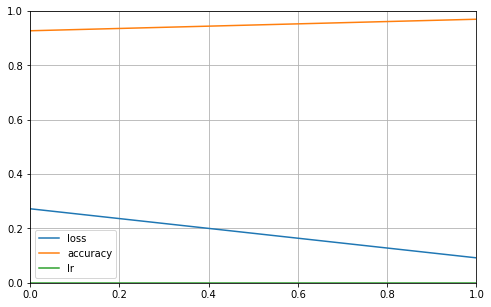

In [15]:
import pandas as pd
pd.DataFrame(h.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [16]:
loadModel()

In [17]:
predictions = model.evaluate(x_test, y_test)

1100/1100 [==============================] - 91s 83ms/step


In [21]:
print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

LOSS : 0.13485330222818945
ACCURACY : 0.9854545593261719


Mean =  20


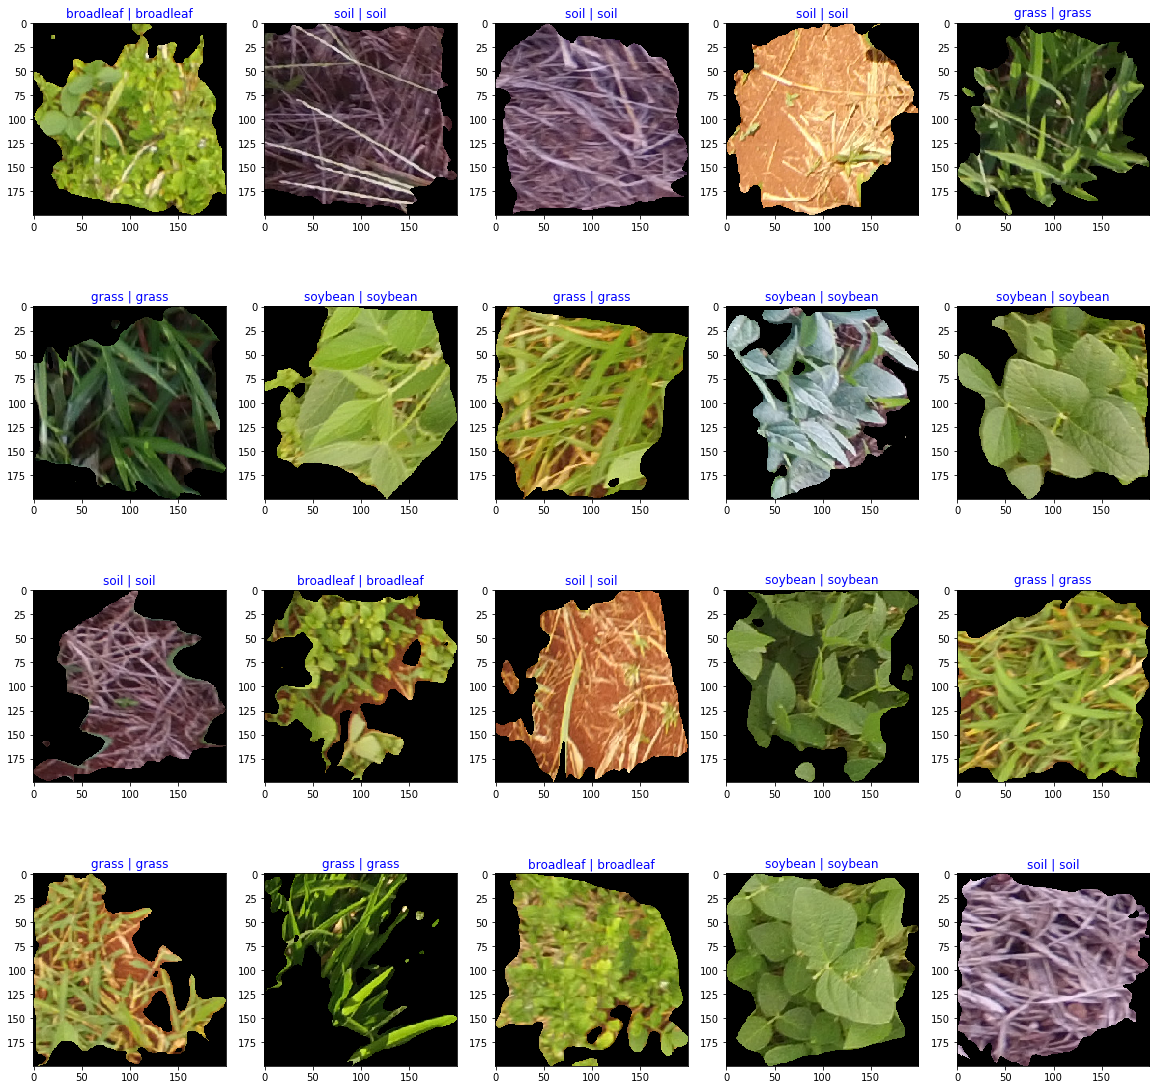

In [51]:
qtdElements = 20
batch_holder = np.zeros((qtdElements, width, height, 3))
correct_label = [0] * qtdElements
data = []
shuffle(all_files)
for i,file, in enumerate(all_files[0:qtdElements]):
    correct_label[i] = file.split("/")[1].split("\\")[0]
    img = image.load_img(file, target_size=(width,height))
    batch_holder[i, :] = img
    img_array = cv2.resize(cv2.imread(file), (width, height))
    data.append(img_array)

x_valid = np.array(data)
result = model.predict(x_valid)

mean = qtdElements
fig = plt.figure(figsize=(20, 20))
for i,img in enumerate(batch_holder):
    fig.add_subplot(4,5, i+1)
    img_result = np.argmax(result[i])
    title = classes[img_result] + ' | ' + correct_label[i]
    color = 'blue'
    if classes[img_result] != correct_label[i] :
        color = 'red'
        mean -=1;
    plt.title(title, color=color)
    plt.imshow(img/256.)

print('Mean = ', mean)
plt.show()

### Lib Versions

In [ ]:
import tensorflow
import matplotlib
import keras
print('Tensorflow:', tensorflow.__version__)
print('Keras:', keras.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)